In [1]:
import os
import sys
sys.path.append(r'C:\Study\SpeechAcquisitionModel')
print(os.getcwd())
import numpy as np
from scipy.spatial.distance import euclidean, minkowski
from sklearn.metrics import precision_recall_curve, average_precision_score
import yaml
from pprint import pprint

import random
import scipy
import torch

import dtw
import dtwalign
from fastdtw import fastdtw

from sklearn.manifold import TSNE
import pandas as pd

from src.speech_classification.audio_processing import SpeechCommandsDataCollector, AudioPreprocessorMFCCDeltaDelta
from src.siamese_net_sound_similarity.slstm_train import SiameseSpeechCommandsDataCollector
from src.siamese_net_sound_similarity.train_v2_with_settle_structure import SiameseDeepLSTMNet
from src.siamese_net_sound_similarity.train import SiameseLSTMNet

from src.siamese_net_sound_similarity.soft_dtw import SoftDTW


import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
sns.set(font_scale=1.4, rc={'text.usetex' : False})
sns.set_style("whitegrid")

%matplotlib inline

C:\Study\SpeechAcquisitionModel\src\dtw


In [2]:
DISTANCE='euclidean'
STEP_PATTERN = 'typeIc'
CLOSED_END_STEP_PATTERN = "typeIc"
# DISTANCE=lambda x, y : minkowski(x,y, 1)

## Load data

In [3]:
config_path = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_01_09_2020_05_52_PM\config.yaml'
with open(config_path, 'r') as data_file:
    config = yaml.safe_load(data_file)
pprint(config)

{'batch_norm': True,
 'dct_coefficient_count': 13,
 'dist': 'l1',
 'dropout': 0.3,
 'hidden_fc': [1024, 1024, 1024],
 'hidden_reccurent': [512, 512, 512],
 'label_count': 32,
 'learning_rate': 0.0005,
 'loss_type': 'sdtw',
 'margin': 0.4,
 'mfcc_num': 39,
 'mini_batch_size': 64,
 'open_end': False,
 'save_dir': "r'C:\\Study\\SpeechAcquisitionModel\\models\\siamese_net_sound_similarity'",
 'train_steps': 100000,
 'triplet_anneal_b': 1500,
 'triplet_anneal_k': 0.0025,
 'wanted_words': ['bed',
                  'bird',
                  'cat',
                  'dog',
                  'down',
                  'eight',
                  'five',
                  'four',
                  'go',
                  'happy',
                  'house',
                  'left',
                  'marvin',
                  'nine',
                  'no',
                  'off',
                  'on',
                  'one',
                  'right',
                  'seven',
             

In [4]:
wanted_words = config['wanted_words']

wanted_words_combined = wanted_words

model_settings = config
query_length = 100

In [5]:
preproc = AudioPreprocessorMFCCDeltaDelta(numcep=model_settings['dct_coefficient_count'], winlen=model_settings['winlen'],
                                     winstep=model_settings['winstep'])

data_iter = SiameseSpeechCommandsDataCollector(preproc,
                                        data_dir=r'C:\Study\Speech_command_classification\speech_dataset',
                                        wanted_words=wanted_words_combined,
                                        testing_percentage=10,
                                        validation_percentage=10
                                        )

index_to_word = {v:k for k,v in data_iter.word_to_index.items()}

# Gather Data for analysis

In [6]:
n_mini_batch_size = 4000

# gather data


data = data_iter.get_data(n_mini_batch_size, 0, 'validation')
labels = data['y']

data1 = data_iter.get_data(n_mini_batch_size, 0, 'validation')
labels1 = data1['y']
idx = np.random.randint(0, len(labels1), len(labels1))
data1_x = data1['x'][idx]
data1['x'] = data1_x
labels1 =  np.array(data1['y'])[idx]
data1['y'] = labels1

# labesl1 = data1['y']

# duplicates = data_iter.get_duplicates(labels, 0, 'testing')
# assert np.any(labels == duplicates['y'])
# duplicates['x'] = duplicates['x'][:n_duplicates_size]
# print(duplicates['x'].shape)

# non_duplicates = data_iter.get_nonduplicates(labels, 0, 'testing')
# assert np.any(labels != non_duplicates['y'])

# y_true = np.concatenate((np.ones((n_duplicates_size)), np.zeros((n_mini_batch_size))))
y_true = labels==labels1
print(y_true)
print(labels)
print(labels1)
print(sum(y_true))
print(data['x'].shape)
dists = []

[False False False ... False False False]
[17. 23.  9. ... 26.  9. 15.]
[14.  6. 28. ... 19.  7.  6.]
153
(4000, 99, 39)


## 1. MFCC Precision/Recall

In [7]:

# initialize dist_lists

dtw = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = data['x'][i].squeeze()
    y = data1['x'][i].squeeze()
    dtw.append(dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=False, dist_only=True).normalized_distance)

mfcc_dtw_dist = np.array(dtw)
dists.append(mfcc_dtw_dist)

# 2. Improving DTW using latent variables from LSTM classifier as a signal

In [8]:
# load nn

nn_ce = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_01_09_2020_05_52_PM\net_43000_0.921875.net'
nn_ce_l2 = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_01_18_2020_03_58_PM\net_9500_0.9609375.net'
nn_ce_dtw = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_01_13_2020_03_27_PM\net_49000_0.9140625.net'
nn_ce_cos = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_01_15_2020_03_09_PM\net_1981_0.9453125.net'

nn_dtw = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_01_17_2020_08_47_PM\net_44000_0.0546875.net'
nn_cos_hinge = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_01_17_2020_04_00_PM\net_15500_0.0546875.net'
nn_l2 = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_01_18_2020_01_26_PM\net_15500_0.046875.net'
# net_237_0.10546875

nn_fnames = [nn_cos_hinge, nn_dtw, nn_l2, nn_ce, nn_ce_l2, nn_ce_cos, nn_ce_dtw]
nn_names = ['COS_HINGE', 'DTW', 'L2', 'CE', 'CE+L2', 'CE+COS_HINGE', 'CE+DTW']


# nn_fnames = [nn_cos_hinge, nn_dtw]
# nn_names = ["COS_HINGE", 'DTW']

model_names = ['MFCC']
model_names.extend(nn_names)


### 2.2 - SOFT-DTW

In [10]:

soft_dtw_loss_close_end = SoftDTW(open_end=False, dist='l1')
dist_funcs = {
    'sdtw': soft_dtw_loss_close_end,
    'l2': lambda x, y: torch.sum((x - y)**2, dim=-1)[-1],
    'cos_hinge': lambda x, y: 1 - torch.nn.CosineSimilarity(dim=0)(x[-1, :], y[-1, :]),
    'ce': soft_dtw_loss_close_end
}


for i in range(len(nn_fnames)):
    nn_fname = nn_fnames[i]
    config_path = os.path.join(os.path.dirname(nn_fname), 'config.yaml')
    with open(config_path, 'r') as data_file:
        config = yaml.safe_load(data_file)
   
    loss_type = config['loss_type']
    dist_func = dist_funcs[loss_type]
    nn = torch.load(nn_fname).cpu()
    nn.eval()

    print(f"############################################################################\n\
# Model {model_names[i+1]}\n\
############################################################################")

    PREFIX_LENS = [100]

    for PREFIX_LEN in PREFIX_LENS:
        print(f"############################################################################\n\
# PREFIX LENGTH : {PREFIX_LEN}\n\
############################################################################")
        nn_input = torch.from_numpy(data['x'][:, :PREFIX_LEN, :]).float()


        z, *_ = nn.single_forward(nn_input)
        z = z

        z1, *_ = nn.single_forward(torch.from_numpy(data1['x']).float())
        z1 = z1


        ###########################################################################
        # DTW
        ###########################################################################

#         soft_dtw_loss_open_end = SoftDTW(open_end=True, dist='l1')
#         soft_dtw_loss_close_end = SoftDTW(open_end=False, dist='l1')

        ##########################################################################
        # OPEN END = False
        ##########################################################################

        # initialize dist_lists

        dtw_z = []

        for i in range(n_mini_batch_size):
            print(i, end='\r')
            x = z[i].squeeze()
            y = z1[i].squeeze()

            d = dist_func(x, y)
            dtw_z.append(d.detach().cpu().numpy())

        dtw_dist = np.array(dtw_z)
        dists.append(dtw_dist)
        
        del z, z1, _


############################################################################
# Model COS_HINGE
############################################################################
############################################################################
# PREFIX LENGTH : 100
############################################################################
############################################################################
# Model DTW
############################################################################
############################################################################
# PREFIX LENGTH : 100
############################################################################
############################################################################
# Model L2
############################################################################
############################################################################
# PREFIX LENGTH : 100
##############################################

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'src.siamese_net_sound_similarity.train_v2_with_settle_structure.SiameseDeepLSTMNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


############################################################################
# Model CE
############################################################################
############################################################################
# PREFIX LENGTH : 100
############################################################################


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 8192000 bytes. Buy new RAM!


# 3. mAP

## 3.1 Precision_Recall Curve

MFCC
-


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


COS_HINGE
-
DTW
-
L2
-
CE
--


IndexError: list index out of range

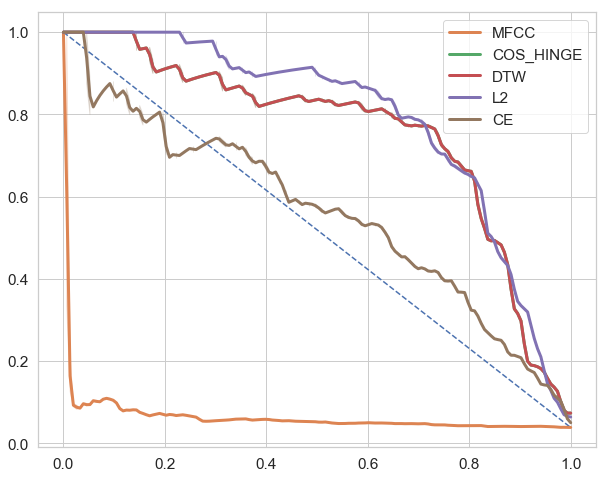

In [11]:
plt.figure(figsize=(10,8))

# no skill model
precision, recall, _ = precision_recall_curve(y_true, np.zeros(len(y_true)), pos_label=1)
ax = sns.lineplot(recall, precision)
ax.lines[0].set_linestyle("--")


for i in range(len(model_names)):
    precision, recall, thresholds = precision_recall_curve(y_true, -dists[i], pos_label=1)
    print(model_names[i])
    if model_names[i].startswith('CE'):
        st = '--'
    else:
        st = '-'
    print(st)
    sns.lineplot(recall, precision, label=model_names[i], linewidth=3
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

## 3.2 Average Precision 

In [12]:
for i in range(len(model_names)):
    average_precision = average_precision_score(y_true, -dists[i])
    print(model_names[i], average_precision)
#     precision, recall, thresholds = precision_recall_curve(y_true, models_dists[i])

MFCC 0.0669538457169294
COS_HINGE 0.7550995088334623
DTW 0.7550995088334623
L2 0.7901247381918121
CE 0.5618266108665679


IndexError: list index out of range